## Creating of the Tfrecord with float32 (saved as string!)
### This code is capable of save a tfrecord with all slices of all images, load them and reconstruct the volume

In [ ]:
import os
def get_folder_list(rootdir):
    dir_list = list()
    
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            dir_list.append(d)
    dir_list.sort()
    return (dir_list)

def get_files_list(rootdir):
    label_list = list()
    image_list = list()

    dir_list = get_folder_list(rootdir=rootdir)
    for folder in dir_list:
        files = os.listdir(folder)
        for file in files:
            if file.endswith("right-labels.nii.gz"):
                label_list.append(os.path.join(folder,file))
            elif file.endswith(".nii.gz") and not file.endswith("right-labels.nii.gz") and not file.endswith("left-labels.nii.gz"):
                
                image_list.append(os.path.join(folder,file))
    return image_list, label_list
        

In [ ]:
import numpy as np
import tensorflow as tf 
import nibabel as nib
from nilearn import plotting #just for visualization 
from matplotlib import pyplot as plt #just for visualization 

def visualization(data_raw, shape = (256, 256, 46)):
	features = np.frombuffer(data_raw, dtype=np.float32)
	print(features.shape)
	features = features.reshape(shape)
	print(features.shape)

	nii = nib.Nifti1Image(np.squeeze(features), affine=np.eye(4))
	plotting.plot_anat(nii)

def render_example(image):
  f, ax = plt.subplots(1, 2, figsize=(10, 10))
  ax[0].imshow(image*0.5 + 0.5)
  ax[0].axis("off")
 

def mid_slices(shape):
	last_dim = shape[-1]
	min = (last_dim - 32) / 2
	max = (last_dim - 32) / 2 + 32

	return int(min), int(max)


rootdir = "/homes/andre.ferreira/UViM/olfactory_bulb/olfactory_bulb_dataset/datasetAnosmie"
image_list, label_list = get_files_list(rootdir)

# path to save the TFRecords file
train_filename = 'olfactory_bulb_nii_dataset-train.tfrecords'
# open the file
writer = tf.io.TFRecordWriter(train_filename)

def _bytes_feature(value):
	return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

for index in range(len(image_list)):

	nii_brain = image_list[index]
	nii_label = label_list[index]

	# Read the .nii image containing the volume with nibabel:
	read_nii_brain = nib.load(nii_brain)
	read_nii_label = nib.load(nii_label)

	# Reshape
	min, max = mid_slices(shape = read_nii_brain.shape)
	read_nii_brain = read_nii_brain.slicer[:,:, min:max]
	read_nii_label = read_nii_label.slicer[:,:, min:max]

	print(f"The brain has shape: {read_nii_brain.shape}")
	print(f"The label has shape: {read_nii_label.shape}")

	# The volume, in numpy format
	array_nii_brain = read_nii_brain.get_fdata().astype('float32')
	array_nii_label = read_nii_label.get_fdata().astype('float32')

	for idx_slice in range(32):
		array_brain_slice = array_nii_brain[:, :, idx_slice]
		array_label_slice = array_nii_label[:, :, idx_slice]
		
		# The volume, to string
		brain_raw = array_brain_slice.tobytes()
		label_raw = array_label_slice.tobytes()
		

		data_point = tf.train.Example(features=tf.train.Features(feature={
			'image_raw': _bytes_feature(brain_raw), 'label_raw': _bytes_feature(label_raw)}))
    
		writer.write(data_point.SerializeToString())


writer.close()

The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 256, 32)
The brain has shape: (256, 256, 32)
The label has shape: (256, 2

image.shape: (256, 256, 32)
label.shape: (256, 256, 32)


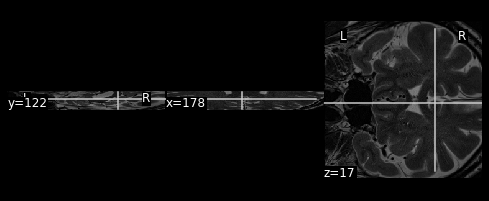

In [ ]:
import tensorflow as tf 
import nibabel as nib
import numpy as np
from nilearn import plotting #just for visualization 

def decode(serialized_example):
    # Decode examples stored in TFRecord
    # NOTE: make sure to specify the correct dimensions for the images 256, 256, 46, 1
    features = tf.io.parse_single_example(
        serialized_example,
        features={'image_raw': tf.io.FixedLenFeature([], tf.string),
                  'label_raw': tf.io.FixedLenFeature([], tf.string)})

    # NOTE: No need to cast these features, as they are already `tf.float32` values.
    return features


def reshape(example) ->tf.Tensor:

    label_1d = tf.io.decode_raw(input_bytes=example['label_raw'], out_type=tf.float32)
    sample_1d = tf.io.decode_raw(input_bytes=example['image_raw'], out_type=tf.float32)
    
    
    label_restored = tf.reshape(label_1d, tf.stack([256, 256]))
    sample_restored = tf.reshape(sample_1d, tf.stack([256, 256]))

    return sample_restored, label_restored

def twoDto3d(images, labels):
    image = images[0]
    label = labels[0]

    for idx in range(1, len(images)):
        image = np.append(arr = image, values = images[idx], axis=None)

    for idx in range(1, len(labels)):
        label = np.append(arr = label, values = labels[idx], axis=None)

    return image.reshape((256, 256, 32), order='F'), label.reshape((256, 256, 32), order='F') 


def read_tfrecord():
    train_filename = "/homes/andre.ferreira/UViM/olfactory_bulb_nii_dataset-train.tfrecords"
    batch_size = 32

    dataset = tf.data.TFRecordDataset(train_filename).map(decode).map(reshape)
    dataset = dataset.repeat(None)
    dataset = dataset.batch(batch_size)

    (image, labels) = next(dataset.as_numpy_iterator())

    image, label = twoDto3d(images = image, labels = labels)
    print(f"image.shape: {image.shape}")
    print(f"label.shape: {label.shape}")

    nii = nib.Nifti1Image(np.squeeze(image), affine=np.eye(4))
    plotting.plot_anat(nii)
    nib.save(nii, 'test5d.nii.gz')

    
read_tfrecord()